# Feature Engineering

In this notebook, the data that we are using will be aggregated on an hourly basis so that we can use it for predictive analysis. In the next step we will engineer new features from the given data as well as other sources. Lastly, we select features that we want to keep in our predictive analysis and features we want to drop using lasso regression and feature correlation.

In [141]:
# First we import all needed libraries
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error
import requests
import concurrent.futures
import geopandas as gpd
from shapely.geometry import Point
import numpy as np

## Data aggregation

In order to predict the data on an hourly basis we need to aggregate the data first. To do this, we add the columns "start_time_floored and "end_time_floored" to our table. Their purpose is to match every trip with a specific hour of the day (0-23), based on the floored start or end time of the trip.

In [142]:
# Saving the prepared data to work with it
df_bike_trips = pd.read_parquet('../../data/bike_trips_cleaned.parquet')
df_bike_trips.head(3)

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,end_station_name,start_station_name,duration,start_lat,start_lon,end_lat,end_lon,distance,speed,average_time,date_time,max_temp,min_temp,precip
index,,,,,,,,,,,,,,,,,,,,
0,2016-01-01 00:04:00,2016-01-01 00:14:00,3046,3041,3564,Indego30,"Girard Station, MFL",2nd & Market,0 days 00:10:00,39.949895,-75.143749,39.969241,-75.136180,1.005648,6.033888,2016-01-01 00:09:00,2016-01-01,6.7,6.7,0.0
1,2016-01-01 00:07:00,2016-01-01 00:29:00,3028,3019,2629,Indego30,6th & Race,4th & Bainbridge,0 days 00:22:00,39.940735,-75.149370,39.954694,-75.149496,0.397798,1.084905,2016-01-01 00:18:00,2016-01-01,6.7,6.7,0.0
2,2016-01-01 00:14:00,2016-01-01 00:27:00,3007,3066,3430,Indego30,19th & Lombard,"11th & Pine, Kahn Park",0 days 00:13:00,39.945123,-75.159952,39.945664,-75.173272,1.480278,6.832050,2016-01-01 00:20:30,2016-01-01,6.7,6.7,0.0


In [143]:
# creation of floored start and end time columns
df_bike_trips['start_time_floored'] = df_bike_trips['start_time'].dt.floor('H')
df_bike_trips['end_time_floored'] = df_bike_trips['end_time'].dt.floor('H')

df_bike_trips.head(3)

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,end_station_name,start_station_name,duration,start_lat,...,end_lon,distance,speed,average_time,date_time,max_temp,min_temp,precip,start_time_floored,end_time_floored
index,,,,,,,,,,,,,,,,,,,,,
0,2016-01-01 00:04:00,2016-01-01 00:14:00,3046,3041,3564,Indego30,"Girard Station, MFL",2nd & Market,0 days 00:10:00,39.949895,...,-75.136180,1.005648,6.033888,2016-01-01 00:09:00,2016-01-01,6.7,6.7,0.0,2016-01-01,2016-01-01
1,2016-01-01 00:07:00,2016-01-01 00:29:00,3028,3019,2629,Indego30,6th & Race,4th & Bainbridge,0 days 00:22:00,39.940735,...,-75.149496,0.397798,1.084905,2016-01-01 00:18:00,2016-01-01,6.7,6.7,0.0,2016-01-01,2016-01-01
2,2016-01-01 00:14:00,2016-01-01 00:27:00,3007,3066,3430,Indego30,19th & Lombard,"11th & Pine, Kahn Park",0 days 00:13:00,39.945123,...,-75.173272,1.480278,6.832050,2016-01-01 00:20:30,2016-01-01,6.7,6.7,0.0,2016-01-01,2016-01-01


In [144]:
# calculate the number of starting and ending trips for each hour
starting_trips_grouped = (
    df_bike_trips.groupby(["start_time_floored"])
    .size()
    .to_frame("starting_trips")
)
ending_trips_grouped = (
    df_bike_trips.groupby(["end_time_floored"])
    .size()
    .to_frame("ending_trips")
)

In [145]:
# concatenate the grouped start and ending trips into our new primary dataframe
df_bike_trips_hourly = pd.concat([starting_trips_grouped, ending_trips_grouped], axis=1)

#overview of our new dataframe
df_bike_trips_hourly.head(3)

,starting_trips,ending_trips
2016-01-01 00:00:00,26.0,17.0
2016-01-01 01:00:00,39.0,32.0
2016-01-01 02:00:00,33.0,37.0


## Adding Features

### Most Occuring Starting Neighborhood feature

Now that the data has been aggregated onto an hourly basis, we want to add data for the most occuring starting neighborhood feature into our dataframe. Therefore, we save this data and merge it with our primary dataframe. 
We created this feature so it can give an idea of which areas are more popular for bike rentals. 

In [146]:
most_common_listname = pd.read_parquet('../../data/most_common_starting_neighborhoods.parquet')

In [147]:
#merging new data into our primary dataframe
df_bike_trips_hourly = df_bike_trips_hourly.merge(most_common_listname, left_index=True, right_index=True, how='outer', indicator=True)



In [148]:
#renaming the column for better understanding
df_bike_trips_hourly = df_bike_trips_hourly.rename(columns={'listname': 'Most_Occuring_Starting_Neighborhood'})

#dropping the _merge column as it is irrelevant for our work
df_bike_trips_hourly =df_bike_trips_hourly.drop('_merge', axis=1)

df_bike_trips_hourly.head(3)

,starting_trips,ending_trips,Most_Occuring_Starting_Neighborhood
2016-01-01 00:00:00,26.0,17.0,Old City
2016-01-01 01:00:00,39.0,32.0,Washington Square West
2016-01-01 02:00:00,33.0,37.0,"Kensington, Old"


Now we need check whether there are empty values stored in our dataframe that could distort our results later on.

In [149]:
#output amounts of missing values
df_bike_trips_hourly.isna().sum()

starting_trips                         54
ending_trips                           43
Most_Occuring_Starting_Neighborhood    54
dtype: int64

As we can see, there are some values missing because e.g. trips that have started but don't have a matching ending, so we have to deal with them.
We decided to fill the missing values with 0 or None when it's in the Most_Occuring_Starting_Neighborhood column. 

In [150]:
#replace missing values with 0 or None
df_bike_trips_hourly['starting_trips'] = df_bike_trips_hourly['starting_trips'].fillna(0)
df_bike_trips_hourly['ending_trips'] = df_bike_trips_hourly['ending_trips'].fillna(0)
df_bike_trips_hourly['Most_Occuring_Starting_Neighborhood'] = df_bike_trips_hourly['Most_Occuring_Starting_Neighborhood'].fillna("None") 


In [151]:
#output amounts of missing values
df_bike_trips_hourly.isna().sum()

starting_trips                         0
ending_trips                           0
Most_Occuring_Starting_Neighborhood    0
dtype: int64

We want the values of the Most_Occuring_Starting_Neighborhood column to be numerical rather than strings, so the feature can be used in the feature correlation later on. For this purpose we mapped every neighborhood of the city of Philadelphia with a unique number in the bike_trips notebook. This mapping is used in the following lines to replace the strings with numerical values. Strings that represent missing values (None) are given the number 158 according to our mapping.

In [152]:
%store -r neighborhood_map
df_bike_trips_hourly['Most_Occuring_Starting_Neighborhood'] = df_bike_trips_hourly['Most_Occuring_Starting_Neighborhood'].map(neighborhood_map)

In [153]:
#overview
df_bike_trips_hourly.head(3)

,starting_trips,ending_trips,Most_Occuring_Starting_Neighborhood
2016-01-01 00:00:00,26.0,17.0,109
2016-01-01 01:00:00,39.0,32.0,112
2016-01-01 02:00:00,33.0,37.0,87


In [154]:
df_bike_trips_hourly.to_parquet('../../data/bike_trips_hourly.parquet')

### Weather features

We will be using the maximum temperature, minimum temperature and precipation values from the weather dataset and use it for our predictions. We added these features because precipation and temperatures can impact how many bikes are rented. As seen in our `temporal demand patterns and seasonality` notebook people tend to rent fewer bikes from December until February due to lower temperatures. 

In [155]:
df_weather = pd.read_parquet('../../data/weather_hourly_philadelphia_cleaned.parquet')

In [156]:
# add new columns containing the weather data
df_bike_trips_hourly['max_temp'] = df_weather['max_temp']
df_bike_trips_hourly['min_temp'] = df_weather['min_temp']
df_bike_trips_hourly['precip'] = df_weather['precip']

Again, we have to deal with missing values. In this case we drop them entirely.

In [157]:
df_bike_trips_hourly.isna().sum()

starting_trips                           0
ending_trips                             0
Most_Occuring_Starting_Neighborhood      0
max_temp                               464
min_temp                               464
precip                                 464
dtype: int64

In [158]:
#drop null values
df_bike_trips_hourly = df_bike_trips_hourly.dropna()

In [159]:
#overview
df_bike_trips_hourly.head(3)

,starting_trips,ending_trips,Most_Occuring_Starting_Neighborhood,max_temp,min_temp,precip
2016-01-01 00:00:00,26.0,17.0,109,6.7,6.7,0.0
2016-01-01 01:00:00,39.0,32.0,112,7.2,7.2,0.0
2016-01-01 02:00:00,33.0,37.0,87,6.7,6.7,0.0


### Time related features

There are several time related features we were able to think of. These include the hour of the day, day of the week, month, day of the year, week, date, whether it is a weekday and what season it is. 
We added time related features to our data as they influence i.e. the number of bike rentals during certain hours in a day. We see this in our `temporal demand patterns and seasonality` notebook that fewer bikes are rented during nighttime (0-6am). 
We added the feature `is_weekday` because we observe in the same notebook that there is higher usage of bike rentals during the working days (Mon-Fri).

For the season we first define a method to calculate the appropriate season based on the date. 

In [160]:
def get_season(dates):
    seasons = []
    for date in dates:
        # Extract the month and day from the datetime object
        month = date.month
        day = date.day

        # Define the start and end dates for each season
        spring_start = '03-20'
        spring_end = '06-20'
        summer_start = '06-21'
        summer_end = '09-22'
        fall_start = '09-23'
        fall_end = '12-20'

        # Check which season the input date belongs to
        if (month == 3 and day >= 20) or (month > 3 and month < 6) or (month == 6 and day <= 20):
            seasons.append('1') # Spring
        elif (month == 6 and day >= 21) or (month > 6 and month < 9) or (month == 9 and day <= 22):
            seasons.append('2') # Summer
        elif (month == 9 and day >= 23) or (month > 9 and month < 12) or (month == 12 and day <= 20):
            seasons.append('3') # Fall
        else:
            seasons.append('4') # Winter
    return seasons

In [161]:
# add feature columns and populate them with the appropriate data
df_bike_trips_hourly['hour'] = df_bike_trips_hourly.index.hour
df_bike_trips_hourly['day_of_week'] = df_bike_trips_hourly.index.day_of_week
df_bike_trips_hourly['month'] = df_bike_trips_hourly.index.month
df_bike_trips_hourly['day_of_year'] = df_bike_trips_hourly.index.day_of_year
df_bike_trips_hourly['week'] = df_bike_trips_hourly.index.isocalendar().week.astype('int64')
df_bike_trips_hourly['date'] = df_bike_trips_hourly.index.date.astype('datetime64[ns]')

#is_weekday as binary variable
df_bike_trips_hourly['is_weekday'] = df_bike_trips_hourly['day_of_week'] < 5
df_bike_trips_hourly['is_weekday'] = df_bike_trips_hourly['is_weekday'].astype(int)

# get season and exchange it with numerical value
df_bike_trips_hourly['season'] = get_season(df_bike_trips_hourly['date'])
df_bike_trips_hourly['season'] = df_bike_trips_hourly['season'].astype(int)

#overview
df_bike_trips_hourly.head(3)

,starting_trips,ending_trips,Most_Occuring_Starting_Neighborhood,max_temp,min_temp,precip,hour,day_of_week,month,day_of_year,week,date,is_weekday,season
2016-01-01 00:00:00,26.0,17.0,109,6.7,6.7,0.0,0,4,1,1,53,2016-01-01,1,4
2016-01-01 01:00:00,39.0,32.0,112,7.2,7.2,0.0,1,4,1,1,53,2016-01-01,1,4
2016-01-01 02:00:00,33.0,37.0,87,6.7,6.7,0.0,2,4,1,1,53,2016-01-01,1,4


### Holiday feature 

In this feature we want to determine whether it was a holiday or not at the time at which the bike rides occured. To do this, we first save the federal holidays of the appropriate year listed in a seperate .json file. 

We are assuming that holidays have some impact on the amount of bike rentals, because on certain holidays people might be riding more or fewer bikes (e.g. christmas day).

If we were looking at multiple years we would have to account for dynamic holidays, but luckily this is not necessary. Furthermore, it is noteworthy that in 2021 a new federal holiday was introduced, Juneteenth. However, this is only relevant if we are looking at data from after this holiday was introduced, which we are not.

In [162]:
holidays_file = open("../../data/holidays.json")
holidays_json = json.loads(holidays_file.read())

In [163]:
# create a dataframe from the dictionary, rename, save date in datetime format
holidays_df = pd.DataFrame.from_dict(holidays_json, orient='index', columns=['date']).reset_index()
holidays_df = holidays_df.rename(columns={'date': 'holiday_name'})
holidays_df = holidays_df.rename(columns={'index': 'date'})
holidays_df['date'] = pd.to_datetime(holidays_df['date'])

#overview of holiday dataframe
holidays_df.head(3)

,date,holiday_name
0,2016-01-01,New Year's Day
1,2016-01-18,Martin Luther King Jr. Day
2,2016-02-15,Presidents' Day


In [164]:
# reset index and merge the holidays into our primary dataframe
df_bike_trips_hourly = df_bike_trips_hourly.reset_index().merge(holidays_df, on='date', how='left').set_index('index')

#overview over newly merged dataframe
df_bike_trips_hourly.head(3)

,starting_trips,ending_trips,Most_Occuring_Starting_Neighborhood,max_temp,min_temp,precip,hour,day_of_week,month,day_of_year,week,date,is_weekday,season,holiday_name
index,,,,,,,,,,,,,,,
2016-01-01 00:00:00,26.0,17.0,109,6.7,6.7,0.0,0,4,1,1,53,2016-01-01,1,4,New Year's Day
2016-01-01 01:00:00,39.0,32.0,112,7.2,7.2,0.0,1,4,1,1,53,2016-01-01,1,4,New Year's Day
2016-01-01 02:00:00,33.0,37.0,87,6.7,6.7,0.0,2,4,1,1,53,2016-01-01,1,4,New Year's Day


In [165]:
# create new column is_holiday and save information whether it was a holiday through numerical values. 
df_bike_trips_hourly['is_holiday'] = df_bike_trips_hourly['holiday_name'].notna()
df_bike_trips_hourly['is_holiday'] = df_bike_trips_hourly['is_holiday'].astype(int)

# drop column as it is not important for us anymore
df_bike_trips_hourly = df_bike_trips_hourly.drop(columns=['holiday_name'])

#new overview
df_bike_trips_hourly.head(3)

,starting_trips,ending_trips,Most_Occuring_Starting_Neighborhood,max_temp,min_temp,precip,hour,day_of_week,month,day_of_year,week,date,is_weekday,season,is_holiday
index,,,,,,,,,,,,,,,
2016-01-01 00:00:00,26.0,17.0,109,6.7,6.7,0.0,0,4,1,1,53,2016-01-01,1,4,1
2016-01-01 01:00:00,39.0,32.0,112,7.2,7.2,0.0,1,4,1,1,53,2016-01-01,1,4,1
2016-01-01 02:00:00,33.0,37.0,87,6.7,6.7,0.0,2,4,1,1,53,2016-01-01,1,4,1


In [166]:
df_bike_trips_hourly.to_parquet('../../data/bike_trips_hourly.parquet')

## Feature Correlation

A way to find out if features can be dropped before we include them in our predictive analysis, is by using feature correlation.

A high correlation means that the features are more linearly dependent and have almost the same effect on the dependent variable. When the correlation between two variables is high, meaning the value is bigger 0.7 or smaller than -0.7, one of the two correlated variables can be dropped. 

In [167]:
#drop all the columns that are not numeric columns (The default value of numeric_only in DataFrame.corr will be deprecated in the future)
columns_to_drop_corr = ['date']
# copy df_bike_trips_hourly so we can drop columns that we do not want to drop in the original dataframe
df_bike_trips_corr = df_bike_trips_hourly.copy()
df_bike_trips_corr.drop(columns_to_drop_corr, axis=1, inplace=True)

In [168]:
# table that shows correlation between features
df_bike_trips_corr.corr()

,starting_trips,ending_trips,Most_Occuring_Starting_Neighborhood,max_temp,min_temp,precip,hour,day_of_week,month,day_of_year,week,is_weekday,season,is_holiday
starting_trips,1.000000,0.986824,0.230112,0.367385,0.367965,-0.112003,0.339070,-0.086754,0.225140,0.221598,0.202131,0.112407,-0.199497,-0.042340
ending_trips,0.986824,1.000000,0.228708,0.383563,0.384222,-0.116387,0.365555,-0.086422,0.227017,0.223475,0.203810,0.111463,-0.201071,-0.042724
Most_Occuring_Starting_Neighborhood,0.230112,0.228708,1.000000,0.059789,0.059755,0.008559,0.222418,-0.073092,0.006885,0.005177,-0.002580,0.101253,-0.003712,-0.038665
max_temp,0.367385,0.383563,0.059789,1.000000,0.999684,-0.072206,0.147838,-0.006414,0.211212,0.212795,0.179991,0.016651,-0.542297,-0.072361
min_temp,0.367965,0.384222,0.059755,0.999684,1.000000,-0.079202,0.146652,-0.006564,0.211436,0.213032,0.180394,0.016850,-0.542557,-0.072115
precip,-0.112003,-0.116387,0.008559,-0.072206,-0.079202,1.000000,0.013636,-0.009228,-0.051463,-0.052260,-0.060522,-0.002292,0.017371,0.005585
hour,0.339070,0.365555,0.222418,0.147838,0.146652,0.013636,1.000000,-0.003396,-0.014466,-0.014305,-0.013921,0.002290,0.008032,0.000495
day_of_week,-0.086754,-0.086422,-0.073092,-0.006414,-0.006564,-0.009228,-0.003396,1.000000,-0.008580,-0.008388,0.002763,-0.787167,0.019270,-0.109122
month,0.225140,0.227017,0.006885,0.211212,0.211436,-0.051463,-0.014466,-0.008580,1.000000,0.996513,0.946965,0.004658,-0.018119,0.019396
day_of_year,0.221598,0.223475,0.005177,0.212795,0.213032,-0.052260,-0.014305,-0.008388,0.996513,1.000000,0.946826,0.004154,-0.018615,0.016801


In the next steps we see a visualization of the features with high correlation. We only marked the high correlated features (>0.7 && <-0.7) with different colors, based on the range of high correlation. The values are shown as rounded values. As the  The correlation value of features with itself is equal to 1, so we left them out.

We also printed out the features that have a high correlation. 

<AxesSubplot:>

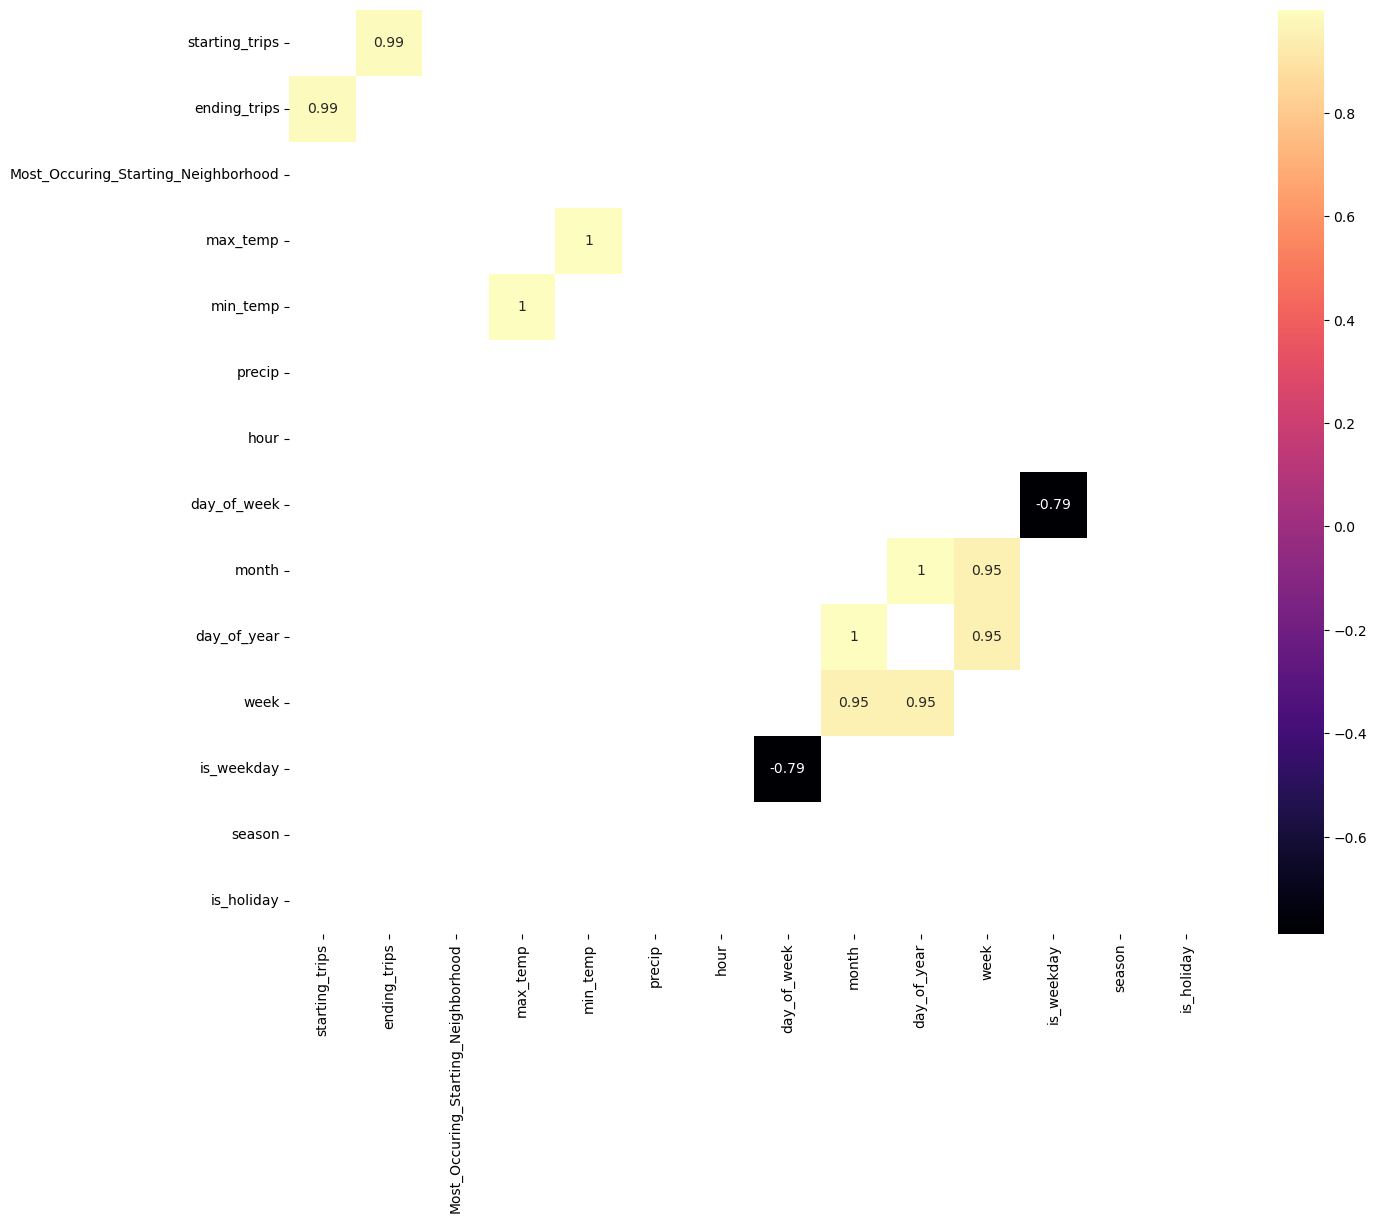

In [169]:
# Visualization from: https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
corr = df_bike_trips_corr.corr()
kot = corr[((corr >= .7) | (corr <= -.7)) & (corr !=1.000)]
plt.figure(figsize=(15,12))
sns.heatmap(kot, annot=True, cmap="magma")

In [170]:
# method from: https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

corrFilter(df_bike_trips_corr, .7)

day_of_week     is_weekday       -0.787167
day_of_year     week              0.946826
month           week              0.946965
starting_trips  ending_trips      0.986824
month           day_of_year       0.996513
max_temp        min_temp          0.999684
starting_trips  starting_trips         NaN
dtype: float64

In [171]:
# checking again for null values because of the NaN value in corrFilter()
df_bike_trips_hourly.isna().sum()

starting_trips                         0
ending_trips                           0
Most_Occuring_Starting_Neighborhood    0
max_temp                               0
min_temp                               0
precip                                 0
hour                                   0
day_of_week                            0
month                                  0
day_of_year                            0
week                                   0
date                                   0
is_weekday                             0
season                                 0
is_holiday                             0
dtype: int64

### Drop features

Looking at the *Feature Correlation* seven pairs have high correlation, while one pair is a correlation between itself. The relationship of the feature with itself can be ignored, so we will not drop the feature. Either of the high correlated features can be dropped, so we chose to drop:  
`day_of_week`, `max_temp`. `day_of_year`, `ending_trips` and `week`.

Additionally we drop the feature `date`, as it is already represented in our index. 

In [172]:
columns_to_drop = ['ending_trips', 'max_temp', 'day_of_week', 'day_of_year', 'week', 'date']
df_bike_trips_hourly.drop(columns_to_drop, axis=1, inplace=True)
df_bike_trips_hourly.head(3)

,starting_trips,Most_Occuring_Starting_Neighborhood,min_temp,precip,hour,month,is_weekday,season,is_holiday
index,,,,,,,,,
2016-01-01 00:00:00,26.0,109,6.7,0.0,0,1,1,4,1
2016-01-01 01:00:00,39.0,112,7.2,0.0,1,1,1,4,1
2016-01-01 02:00:00,33.0,87,6.7,0.0,2,1,1,4,1


In [173]:
# save dataframe into data
df_bike_trips_hourly.to_parquet('../../data/bike_trips_hourly.parquet')

## Lasso regression with alpha=1

Another way to find out if features can be dropped is through the Lasso regression. When the feature value equals 0 the feature can be dropped.
The `input_features` are here equivalet to our future X value and `predicted_variable` to our future Y value. 

In [174]:
input_features = df_bike_trips_hourly.drop(columns=["starting_trips"])
predicted_variable = df_bike_trips_hourly["starting_trips"]

In [175]:
# scale input features
scaler = StandardScaler()
input_features_scaled = scaler.fit_transform(input_features.values)

In [176]:
input_features.head(3)

,Most_Occuring_Starting_Neighborhood,min_temp,precip,hour,month,is_weekday,season,is_holiday
index,,,,,,,,
2016-01-01 00:00:00,109,6.7,0.0,0,1,1,4,1
2016-01-01 01:00:00,112,7.2,0.0,1,1,1,4,1
2016-01-01 02:00:00,87,6.7,0.0,2,1,1,4,1


In [177]:
# fit data to the linear regression model
model = Lasso(alpha=1)
model.fit(input_features_scaled, predicted_variable)
print("Coefficients ", model.coef_)


Coefficients  [ 9.97690254 17.56124583 -5.57705184 19.63320462 11.83755163  5.96184028
 -3.99450797 -0.79419651]


## Lasso with optimal alpha

During our research phase we found that there is a way to find an optimized alpha value for better coefficients. This is what we implement below.

### K-fold cross validation
From: https://www.kirenz.com/post/2019-08-12-python-lasso-regression-auto/

In [178]:
# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=0, max_iter=10000)

# Fit model
model.fit(input_features_scaled, predicted_variable)

LassoCV(cv=5, max_iter=10000, random_state=0)

In [179]:
model.alpha_

0.17965357291559964

### Best model

In [180]:
# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(input_features_scaled, predicted_variable)

Lasso(alpha=0.17965357291559964)

In [181]:
print(list(zip(lasso_best.coef_, input_features)))

[(10.521217577901039, 'Most_Occuring_Starting_Neighborhood'), (17.541955481309994, 'min_temp'), (-6.3536943872008145, 'precip'), (20.3617855026273, 'hour'), (12.627363235043923, 'month'), (6.774768279202687, 'is_weekday'), (-4.731302092765362, 'season'), (-1.6035590903355703, 'is_holiday')]


### Model evaluation

In [182]:
print('R squared training set', round(lasso_best.score(input_features_scaled, predicted_variable)*100, 2))
print('R squared test set', round(lasso_best.score(input_features_scaled, predicted_variable)*100, 2))


R squared training set 28.71
R squared test set 28.71


In [183]:
mean_squared_error(predicted_variable, lasso_best.predict(input_features_scaled))

3925.9249354938756

Here we repeat the lasso regression with the optimized alpha value we calculated before.

In [184]:
model = Lasso(alpha=0.17965357291559964)
model.fit(input_features_scaled, predicted_variable)
print("Coefficients ", model.coef_)


Coefficients  [10.52121758 17.54195548 -6.35369439 20.3617855  12.62736324  6.77476828
 -4.73130209 -1.60355909]


In [185]:
df_bike_trips_hourly.to_parquet('../../data/bike_trips_hourly_FINAL.parquet')